# Using JATIC's Image Classification Protocol with `xaitk-saliency`

This is a simple notebook demonstrating how classifiers based on JATIC's image classification protocol can interface with `xaitk-saliency`.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Example Image](#example-image)
* [Instantiate Protocol-Based Classifier](#instantiate-protocol-based-classifier)
* [Transform Protocol-Based Classifier](#transform-protocol-based-classifier)
* [Use the Classifier as "Normal"](#use-detector-as-normal)
    * [Generate Saliency Maps](#generate-saliency-maps)
        * [Saliency Generation](#saliency-generation)
        * [Display Saliency Maps](#display-saliency-maps)
    

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing xaitk-jatic...")
!{sys.executable} -m pip install -q xaitk-jatic
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets==2.15.0
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip install -q torchvision
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Done!")

Installing xaitk-jatic...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing torch...
Installing torchvision...
Installing matplotlib...
Done!


In [ ]:
%matplotlib inline
import time
from collections.abc import Hashable, Sequence

import maite.protocols.image_classification as ic
import numpy as np
import torch  # type: ignore
from datasets import load_dataset  # type: ignore
from matplotlib import pyplot as plt  # type: ignore
from transformers import (  # type: ignore
    AutoImageProcessor,  # type: ignore
    AutoModelForImageClassification,  # type: ignore
)
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

from xaitk_jatic.interop.image_classification.model import JATICImageClassifier

/home/local/KHQ/stephen.crowell/.cache/pypoetry/virtualenvs/xaitk-jatic-OReYJURx-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example Image <a name="example-image"></a>

We'll use a single example image from the CIFAR-10 test dataset.

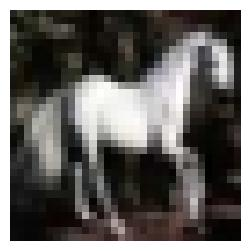

In [3]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

ds = load_dataset("cifar10", split="test")
img = np.asarray(ds[13]["img"])  # type: ignore

plt.figure(figsize=(3, 3))
plt.axis("off")
_ = plt.imshow(img)

## Instantiate Protocol-Based Classifier <a name="instantiate-protocol-based-classifier"></a>

First, we need a classifier that uses the image classification protocol. Here we'll be be wrapping a model from Hugging Face, but this could be **any** model that conforms to the image classification protocol!

In [4]:
class HuggingFaceClassifier:
    """
    A wrapper for a Hugging Face image classification model, providing easy inference functionality.

    Attributes:
        image_processor (AutoImageProcessor): The processor for preparing input images for the model.
        model (AutoModelForImageClassification): The pre-trained Hugging Face model for image classification.
        device (str): The device to run the model on (e.g., "cpu" or "cuda").
    """

    def __init__(self, model_name: str, device: str) -> None:
        """
        Initializes the HuggingFaceClassifier with a pre-trained model and device.

        Args:
            model_name (str): The name of the pre-trained model from Hugging Face.
            device (str): The device to use for running the model (e.g., "cpu" or "cuda").
        """
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)
        self.device = device

        self.model.eval()
        self.model.to(device)

    def id2label(self) -> dict[int, Hashable]:
        """
        Retrieves the mapping of class IDs to labels from the model's configuration.

        Returns:
            Dict[int, Hashable]: A dictionary mapping class IDs to human-readable labels.
        """
        return self.model.config.id2label

    def __call__(self, batch: ic.InputBatchType) -> ic.TargetBatchType:
        """
        Performs image classification on a batch of input images and returns the model's predictions.

        Args:
            batch (ic.InputBatchType): A batch of input images as tensors with shape
                `(batch_size, channels, height, width)`.

        Raises:
            ValueError: If the input batch does not have 4 dimensions.

        Returns:
            ic.TargetBatchType: The predicted class probabilities for the batch.
        """
        # tensor bridging
        model_input = torch.as_tensor(batch)
        if model_input.ndim != 4:
            raise ValueError("Wrong number of input dimensions")

        # preprocess
        hf_inputs = self.image_processor(model_input, return_tensors="pt")

        # put on device
        hf_inputs = hf_inputs.to(self.device)

        # get predictions
        with torch.no_grad():
            return self.model(**hf_inputs).logits.softmax(1).detach().cpu()


jatic_classifier: ic.Model = HuggingFaceClassifier(
    model_name="aaraki/vit-base-patch16-224-in21k-finetuned-cifar10",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

## Transform Protocol-Based Classifier <a name="transform-protocol-based-classifier"></a>

Now that we have our JATIC protocol-based classifier, we can wrap it so that it can be used directly with `xaitk-saliency`.

In [5]:
classifier = JATICImageClassifier(classifier=jatic_classifier, ids=sorted(jatic_classifier.id2label().keys()))

## Use the Classifier as "Normal" <a name="use-classifier-as-normal"></a>

Now the classifier can be used just like it is a regular `ClassifyImage` implementation with `xaitk-saliency`.

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

We'll generate saliency maps for our selected example using the `SlidingWindowStack` implementation.

In [6]:
sal_generator = SlidingWindowStack(window_size=(2, 2), stride=(1, 1), threads=4)
sal_generator.fill = (128, 128, 128)

In [7]:
print("Generating saliency maps...")
start = time.time()
sal_maps = sal_generator(img, classifier)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating saliency maps...


/tmp/ipykernel_174504/2710548664.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  input = torch.as_tensor(batch)


Done in 203.51s


#### Display Saliency Maps <a name="display-saliency-maps"></a>

In [8]:
def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray, labels: Sequence[str]) -> None:
    """
    Visualizes saliency heat-maps for a reference image across multiple classes.

    Args:
        ref_image (np.ndarray): The reference image to overlay saliency maps on.
            Should be in the format (height, width, channels).
        sal_maps (np.ndarray): An array of saliency maps with shape `(num_classes, height, width)`,
            where each saliency map corresponds to a class.
        labels (Sequence[str]): A sequence of class labels corresponding to the saliency maps.

    Returns:
        None: The function directly displays the saliency visualizations using Matplotlib.
    """
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(24, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis("off")
    plt.title("Test Image")

    for i, class_sal_map in enumerate(sal_maps):
        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2 + i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(np.clip(class_sal_map, 0, 1), cmap="jet", alpha=0.3)
        plt.clim(0, 1)
        plt.title(f"Pos Saliency:\n{labels[i]}")
        plt.axis("off")

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind + 2 + i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(np.clip(class_sal_map, -1, 0), cmap="jet_r", alpha=0.3)
        plt.clim(-1, 0)
        plt.title(f"Neg Saliency:\n{labels[i]}")
        plt.axis("off")

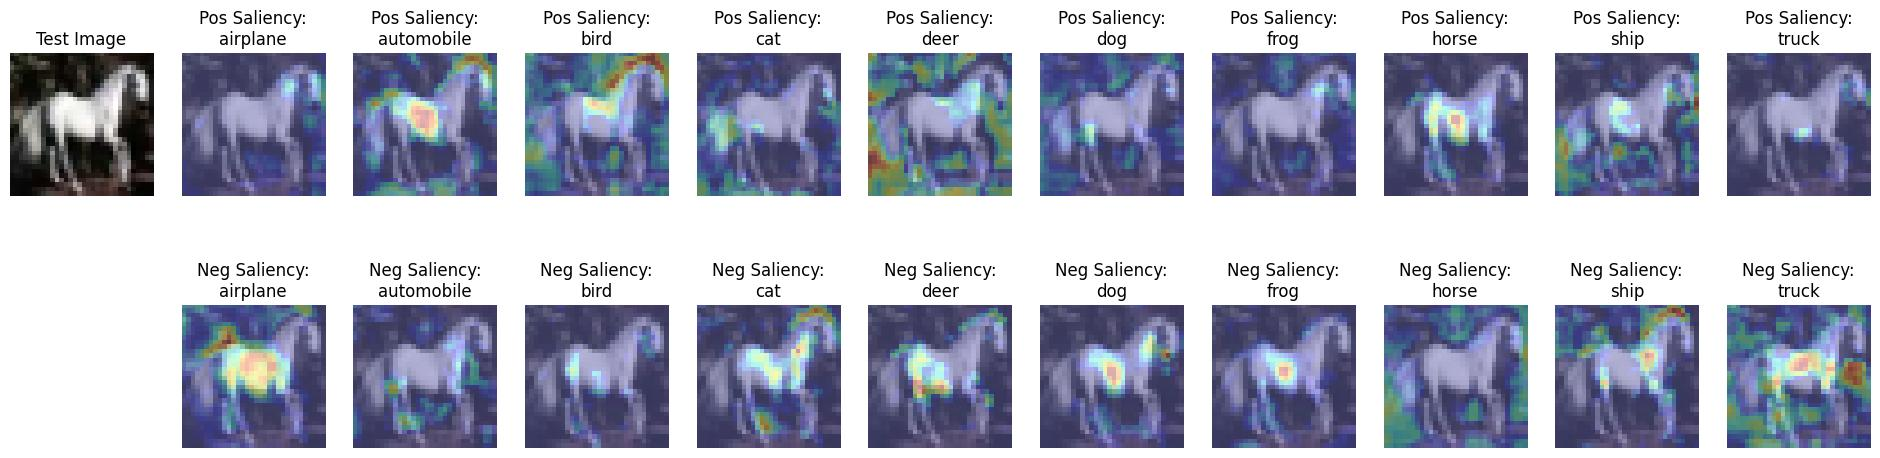

In [9]:
id_2_label = jatic_classifier.id2label()
visualize_saliency(img, sal_maps, [id_2_label[idx] for idx in classifier.get_labels()])  # type: ignore